In [1]:
basepath = 'data'

In [2]:
import os
os.listdir(basepath)

['key_1.csv',
 'key_1.csv.zip',
 'sample_submission_1.csv',
 'sample_submission_1.csv.zip',
 'train_1.csv',
 'train_1.csv.zip']

In [3]:
import pandas as pd

In [4]:
data = pd.read_csv(f'{basepath}/train_1.csv')

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import seaborn as sns
sns.set()

In [7]:
# from https://github.com/thepaulm/pyplot_examples/blob/master/Pyplot%20Examples.ipynb
def pta(*args, color_rotate=True):
    '''pta = plot them all'''
    count = len(args)
    w = 20
    h = 4 * count
    fig = plt.figure(1, figsize=(w, h))
    for i, a in enumerate(args):
        ax = fig.add_subplot(count, 1, i+1)
        if color_rotate:
            for _ in range(i):
                ax.plot([],[])
        ax.plot(a)

In [8]:
# rindex = np.random.randint(0, data.shape[0])
rindex = 144278
rindex

144278

In [9]:
npdata = data[rindex:rindex+1].fillna(0).as_matrix()

In [10]:
npdata = npdata.squeeze()[1:].astype('float32')

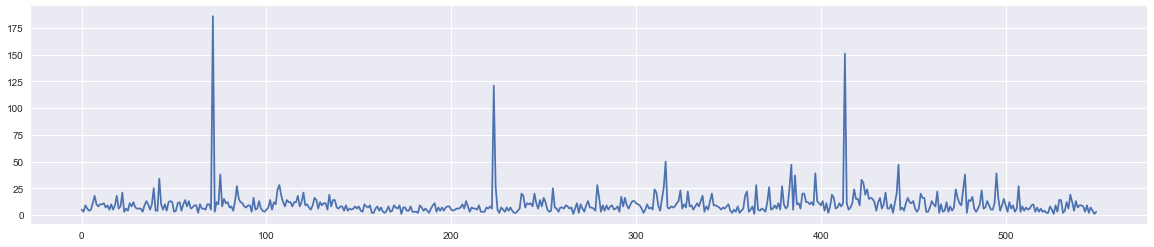

In [11]:
pta(npdata)

In [12]:
def shaperB(data, observations, predictions):
    outX = []
    outY = []
    for a in range(0, len(data) - (observations + predictions)):
        d = data[a:a + observations + predictions]
        outX.append(d[:observations])
        outY.append(d[observations:])
    outX = np.array(outX)
    outY = np.array(outY)
    outX = outX.reshape(outX.shape + (1,))
    outY = outY.reshape(outY.shape + (1,))
    return outX, outY

In [13]:
npdata.shape, npdata[0:94].shape

((550,), (94,))

## Shape it, Scale it, Predict it

In [14]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
npscaled = scaler.fit_transform(npdata.reshape(npdata.shape + (1,))).squeeze()

In [16]:
x, y = shaperB(npscaled[0:94], 1, 1)

In [17]:
x.shape, y.shape

((92, 1, 1), (92, 1, 1))

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed

Using TensorFlow backend.


In [19]:
class TrainContext(object):
    def __init__(self, model, history, train_time):
        self.model = model
        self.history = history
        self.train_time = train_time

def train_model(x, y, units=64, cells=1, lr=1e-3, epochs=32, verbose=False):
    # create and fit the LSTM network
    model = Sequential()
    if cells == 1:
        model.add(LSTM(units, input_shape=x.shape[1:]))
    else:
        model.add(LSTM(units, input_shape=x.shape[1:], return_sequences=True))
        for _ in range(cells-2):
            model.add(LSTM(units, return_sequences=True))
        model.add(LSTM(units))

    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.optimizer.lr = lr
    
    start = timer()
    history = model.fit(x, y, epochs=epochs, batch_size=1, verbose=verbose)
    end = timer()
    return TrainContext(model, history, end-start)

In [20]:
ctx = train_model(x, y.squeeze(axis=2))

In [21]:
figsize = (20, 4)

In [22]:
ctx.train_time

38.0700809810005

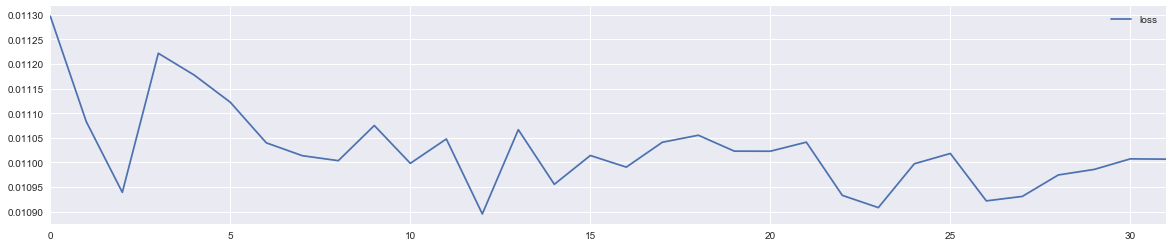

In [23]:
pd.DataFrame({"loss": ctx.history.history['loss']}).plot(figsize=figsize)

In [24]:
ctx.model.save_weights('u64_o1_p2.h5')

# Can we get longer predicts?

In [25]:
x, y = shaperB(npscaled[0:94], 10, 10)

In [26]:
x.shape, y.shape

((74, 10, 1), (74, 10, 1))

In [27]:
ctx = train_model(x, y.squeeze(axis=2))

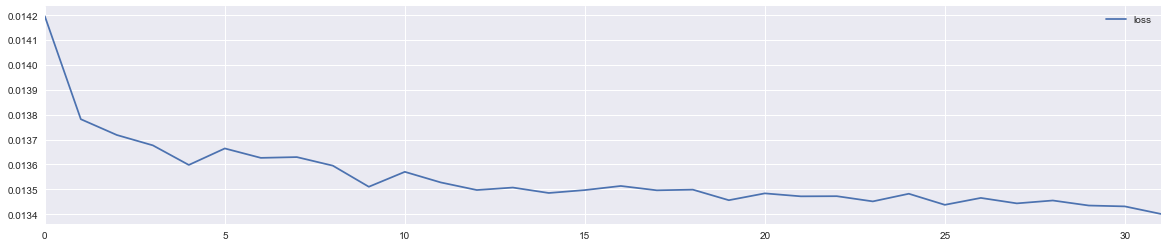

In [28]:
pd.DataFrame({"loss": ctx.history.history['loss']}).plot(figsize=figsize)

In [29]:
ctx.train_time

120.38782449800055

In [31]:
ctx.model.save_weights('u64_o10_p10.h5')

# Can we get different shapes?

In [32]:
x, y = shaperB(npscaled[0:94], 20, 10)

In [33]:
x.shape, y.shape

((64, 20, 1), (64, 10, 1))

In [34]:
ctx = train_model(x, y.squeeze(axis=2))

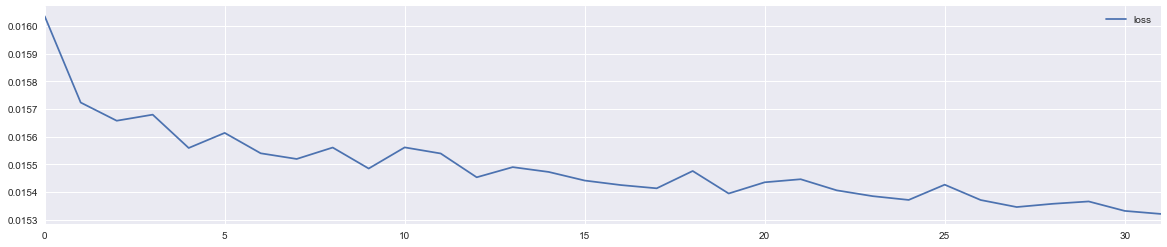

In [35]:
pd.DataFrame({"loss": ctx.history.history['loss']}).plot(figsize=figsize)

In [36]:
ctx.train_time

189.97829678700145

In [37]:
valx, valy = shaperB(npscaled[92:128], 20, 10)

In [38]:
valx.shape, valy.shape

((6, 20, 1), (6, 10, 1))

### function starts here

In [39]:
pred = ctx.model.predict(x)

In [40]:
valpred = ctx.model.predict(valx)

In [41]:
pred.shape, valpred.shape

((64, 10), (6, 10))

In [42]:
def ptt(*args):
    '''ptt = plot them together'''
    count = len(args)
    w = 20
    h = 4
    fig = plt.figure(1, figsize=(w, h))
    ax = fig.add_subplot(1, 1, 1)
    for a in args:
        ax.plot(a)

In [43]:
preds = np.vsplit(pred, pred.shape[0])

In [44]:
preds[0].shape

(1, 10)

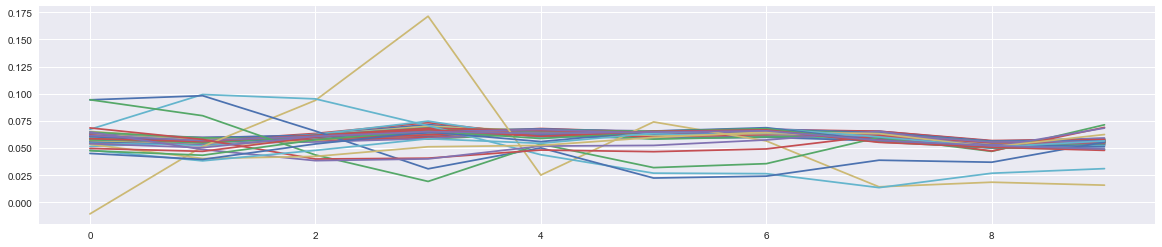

In [45]:
ptt(*[a.squeeze() for a in preds])

In [46]:
print(np.nan)

nan


### Fill in the beggning gaps with nans

In [47]:
# We have this many
len(preds)

64

In [48]:
# Here's how to do one
np.append(np.array([np.nan for _ in range(12)]), preds[12])

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,  0.06140234,  0.05577484,  0.05947132,
        0.06382915,  0.06675423,  0.06367762,  0.06567032,  0.06363935,
        0.05572207,  0.0567779 ])

In [49]:
gps = [np.append(np.array([np.nan for _ in range(i)]), preds[i]) for i in range(len(preds))]

In [50]:
gps[12].shape

(22,)

In [51]:
preds[12].shape

(1, 10)

In [52]:
gps[12]

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,  0.06140234,  0.05577484,  0.05947132,
        0.06382915,  0.06675423,  0.06367762,  0.06567032,  0.06363935,
        0.05572207,  0.0567779 ])

In [53]:
preds[12]

array([[ 0.06140234,  0.05577484,  0.05947132,  0.06382915,  0.06675423,
         0.06367762,  0.06567032,  0.06363935,  0.05572207,  0.0567779 ]], dtype=float32)

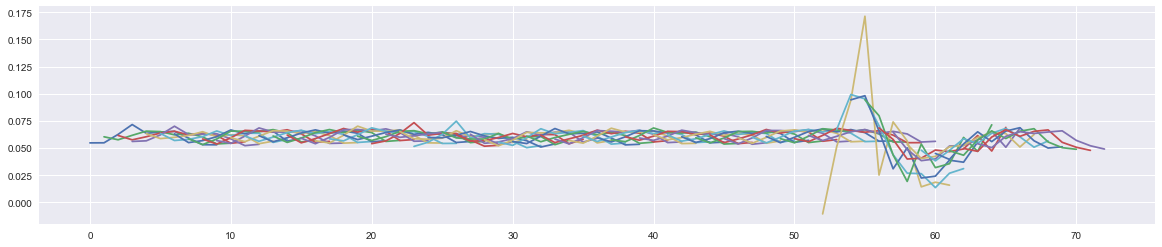

In [54]:
ptt(*gps)

In [55]:
y.shape

(64, 10, 1)

In [56]:
gys = [np.append(np.array([np.nan for _ in range(i)]), y[i]) for i in range(len(y))]

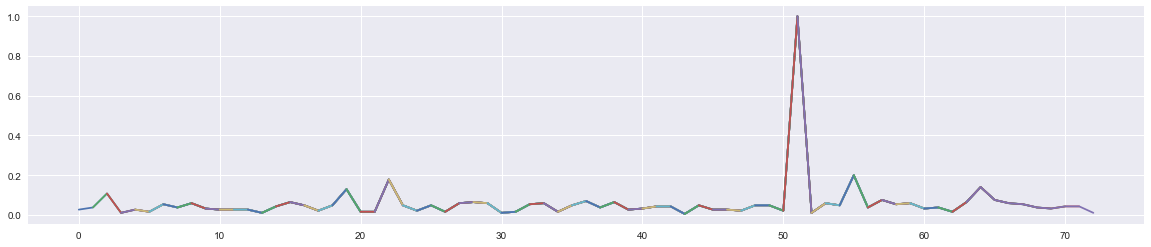

In [57]:
ptt(*gys)

In [58]:
x.shape

(64, 20, 1)

In [59]:
gxs = [np.append(np.array([np.nan for _ in range(i)]), x[i]) for i in range(len(x))]

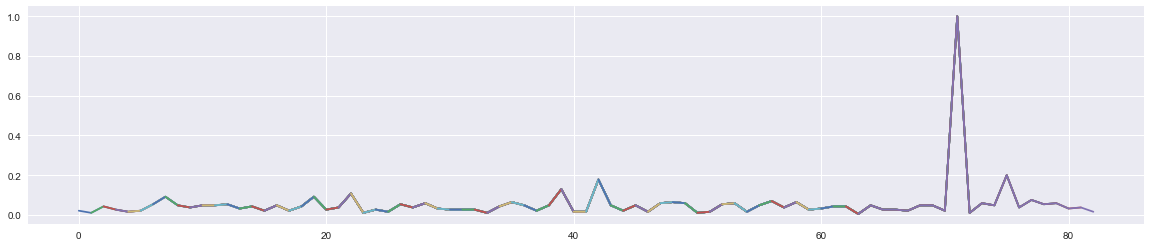

In [60]:
ptt(*gxs)

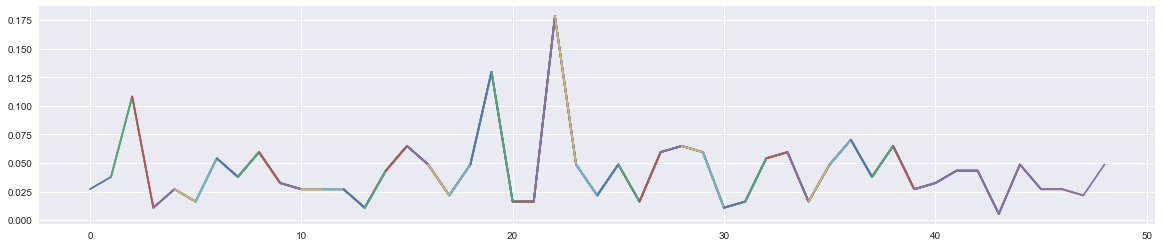

In [61]:
ptt(*gys[:40])

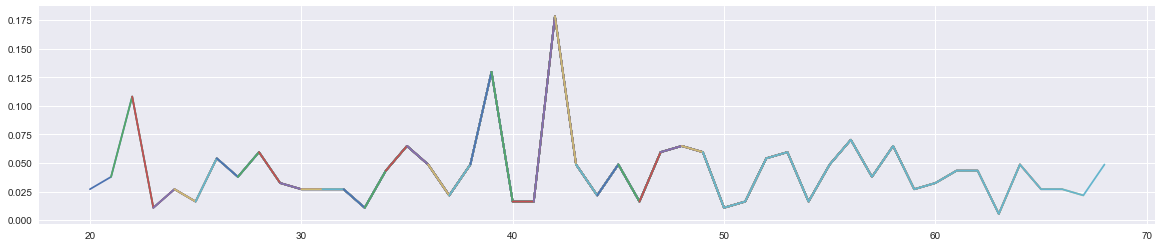

In [62]:
ptt(*gxs[20:50])

# Train Some Better Shit

In [63]:
x, y = shaperB(npscaled, 20, 10)

In [64]:
ctx = train_model(x, y.squeeze(axis=2), units=128)

In [65]:
ctx.train_time / 60.0

24.94994396446667

In [66]:
ctx.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 67,850
Trainable params: 67,850
Non-trainable params: 0
_________________________________________________________________


In [67]:
ctx.model.save_weights('u128_o20_p10.h5')

In [68]:
def plot_loss(ctx):
    pd.DataFrame({"loss": ctx.history.history['loss']}).plot(figsize=figsize)

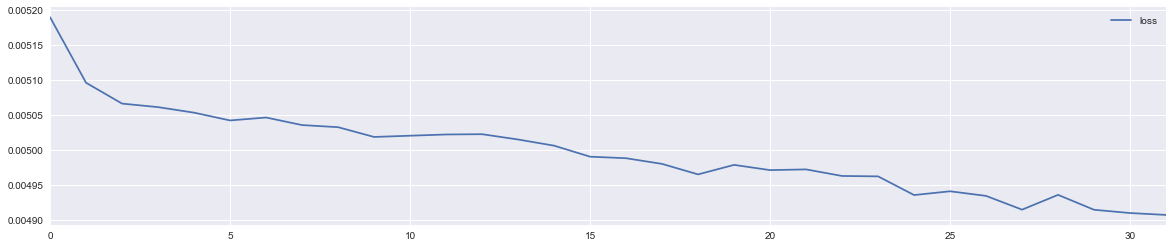

In [69]:
plot_loss(ctx)

### What is the real output here

In [70]:
def plot_offset_predicts(preds):
    return [np.append(np.array([np.nan for _ in range(i)]), preds[i]) for i in range(len(preds))]

In [72]:
x.shape, y.shape

((520, 20, 1), (520, 10, 1))

In [74]:
x[len(x)-1]

array([[ 0.02702703],
       [ 0.01081081],
       [ 0.01621622],
       [ 0.00540541],
       [ 0.00540541],
       [ 0.03783784],
       [ 0.02162162],
       [ 0.        ],
       [ 0.04324324],
       [ 0.01081081],
       [ 0.07027028],
       [ 0.07027028],
       [ 0.00540541],
       [ 0.01621622],
       [ 0.05945946],
       [ 0.02702703],
       [ 0.0972973 ],
       [ 0.05945946],
       [ 0.01621622],
       [ 0.06486487]], dtype=float32)

In [78]:
y[len(y)-21]

array([[ 0.02702703],
       [ 0.01081081],
       [ 0.01621622],
       [ 0.00540541],
       [ 0.00540541],
       [ 0.03783784],
       [ 0.02162162],
       [ 0.        ],
       [ 0.04324324],
       [ 0.01081081]], dtype=float32)

In [85]:
x[len(x)-1].reshape((1,)+x.shape[1:]).shape

(1, 20, 1)

In [86]:
onex = x[len(x)-1].reshape((1,)+x.shape[1:])

In [88]:
p = ctx.model.predict(onex)

In [89]:
p.shape

(1, 10)

In [91]:
y[len(y)-1]

array([[ 0.03243244],
       [ 0.04324324],
       [ 0.04324324],
       [ 0.03783784],
       [ 0.01081081],
       [ 0.04324324],
       [ 0.00540541],
       [ 0.03243244],
       [ 0.01621622],
       [ 0.        ]], dtype=float32)

In [92]:
p

array([[ 0.03983711,  0.05049914,  0.05655351,  0.04762407,  0.05157048,
         0.04185038,  0.04834123,  0.02564121,  0.02958057,  0.04538728]], dtype=float32)

In [95]:
oney = y[len(y)-1]

In [96]:
oney.shape

(10, 1)

In [104]:
def fillna(a, n):
    return np.append(np.array([np.nan for _ in range(n)]), a.squeeze())

In [105]:
fillna(p, 20).shape

(30,)

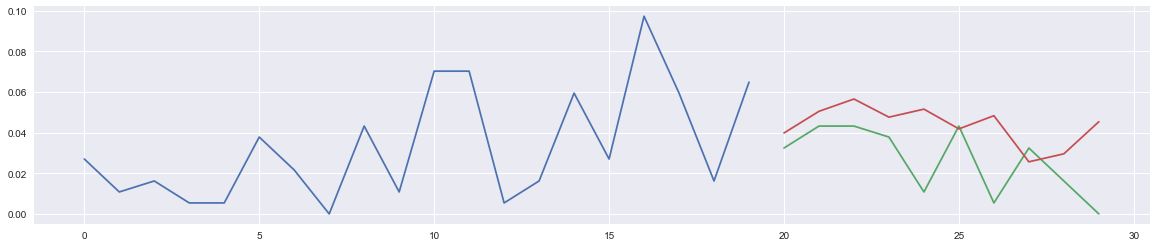

In [108]:
ptt(onex.squeeze(), fillna(oney, 20), fillna(p, 20))

In [109]:
x[len(x)-1]

array([[ 0.02702703],
       [ 0.01081081],
       [ 0.01621622],
       [ 0.00540541],
       [ 0.00540541],
       [ 0.03783784],
       [ 0.02162162],
       [ 0.        ],
       [ 0.04324324],
       [ 0.01081081],
       [ 0.07027028],
       [ 0.07027028],
       [ 0.00540541],
       [ 0.01621622],
       [ 0.05945946],
       [ 0.02702703],
       [ 0.0972973 ],
       [ 0.05945946],
       [ 0.01621622],
       [ 0.06486487]], dtype=float32)

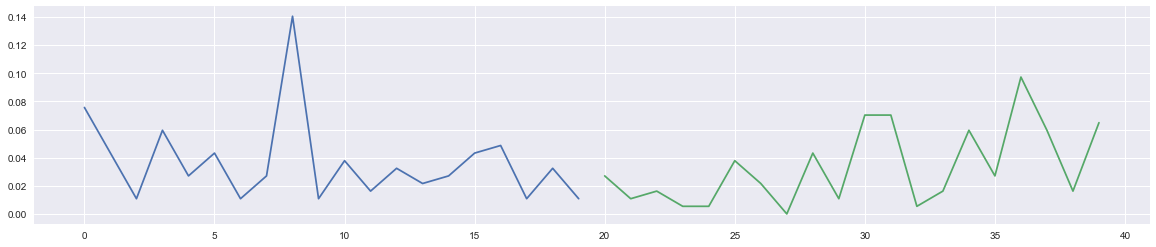

In [117]:
ptt(x[len(x)-21].squeeze(), fillna(x[len(x)-1],20))

In [118]:
def forpred(x, n):
    return x[n].reshape((1,)+x.shape[1:])

In [120]:
xp = forpred(x, len(x)-21)

In [122]:
p = ctx.model.predict(xp)

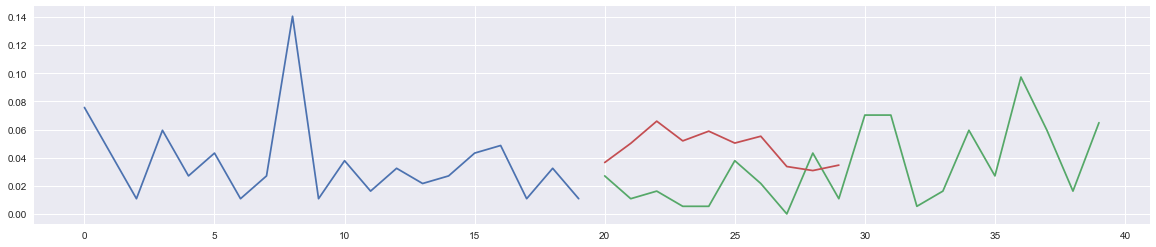

In [123]:
ptt(x[len(x)-21].squeeze(), fillna(x[len(x)-1],20), fillna(p, 20))

In [129]:
def get_preds(ctx):
    preds = {}
    for i in range(10):
        xp = forpred(x, len(x) - (11 + i))
        preds[i] = ctx.model.predict(xp).squeeze()
    return preds

In [130]:
preds = get_preds(ctx)

In [131]:
preds[0].shape

(10,)

In [143]:
ppreds = {}
for k in preds:
    ppreds[k] = fillna(preds[k], 20 + k)

In [150]:
pargs = [v for _, v in ppreds.items()]

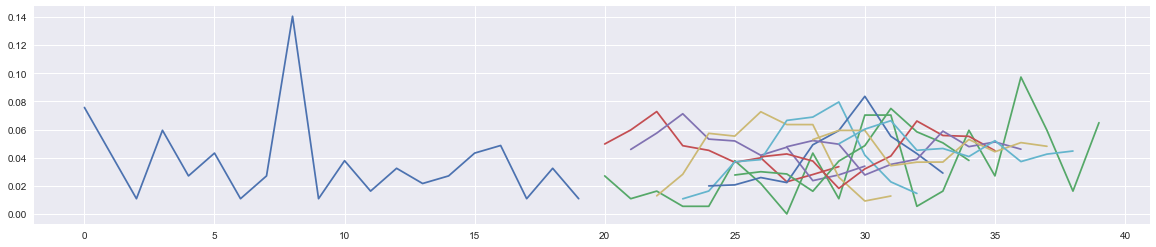

In [154]:
ptt(x[len(x)-21].squeeze(), fillna(x[len(x)-1],20), *pargs)

In [158]:
len(data)

145063